# Consumer Buying Behavior

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import entropy
from sklearn.model_selection import GridSearchCV

# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imblearnPipeline
from sklearn.preprocessing import PowerTransformer

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Functions

In [20]:
def spot_check_models(X,y):
    """
    This a quick way to spot check relevant algorithms to gain an understanding of 
    the dataset and which models handle the distribution well.

    Args:
    X: Pd.Dataframe
    y: Pd.Series

    Returns:
        _type_: Sorted dataframe on accuracy scores.
    """
    models = {
        
        "GaussianNB": GaussianNB(),
        "LDA":LinearDiscriminantAnalysis(),
        "GPC":GaussianProcessClassifier(),
        
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(),
        "KNeighborsClassifier": KNeighborsClassifier(),
        
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "XGB":XGBClassifier()
    }
    
    X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X,y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    model_performance.append({
        "Model": "Sequential",
        "Accuracy": accuracy
    })

    # Convert the model_performance to a DataFrame
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Accuracy", ascending=False)


def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in names]

def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(accuracy_score)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): Pandas DataFrame

  Returns:
      pd.DataFrame: THe Entropy level of all models
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    for i in range(len(models)):
        pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', models[i])])
        # Evaluate the model
        scores = evaluate_model(X, y, pipeline)
        # summarize and store
        print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))


# EDA Analysis

In [3]:
df = pd.read_csv("social_ads.csv")
df

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0
...,...,...,...
395,46,41000,1
396,51,23000,1
397,50,20000,1
398,36,33000,0


# Check For Dupes

In [4]:
print(f"The amount of null values: {df.isna().sum()}")
print(f"The amount of Duplicates: {df.duplicated().sum()}")

The amount of null values: Age                0
EstimatedSalary    0
Purchased          0
dtype: int64
The amount of Duplicates: 33


# Drop Dupes

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.shape

(367, 3)

# Check for Target class Balances

In [9]:
target = df.values[:,-1]

counter = Counter(target)

for k,v in counter.items():
  per = v/len(target) * 100
  print("Class=%d, Count=%d, Percentage=%.3f%%" % (k,v, per))

Class=0, Count=229, Percentage=62.398%
Class=1, Count=138, Percentage=37.602%


# Fairly blanced set of data

In [10]:
df.describe()

,Age,EstimatedSalary,Purchased
count,367.000000,367.000000,367.000000
mean,37.722071,70719.346049,0.376022
std,10.681383,34772.173908,0.485047
min,18.000000,15000.000000,0.000000
25%,29.500000,43000.000000,0.000000
50%,37.000000,71000.000000,0.000000
75%,46.000000,89000.000000,1.000000
max,60.000000,150000.000000,1.000000


# Calculate Entropy

In [11]:
calculate_entropy(df)

,Age,EstimatedSalary,Purchased
entropy,5.208731,6.611593,0.955184


# Visuals

<Axes: >

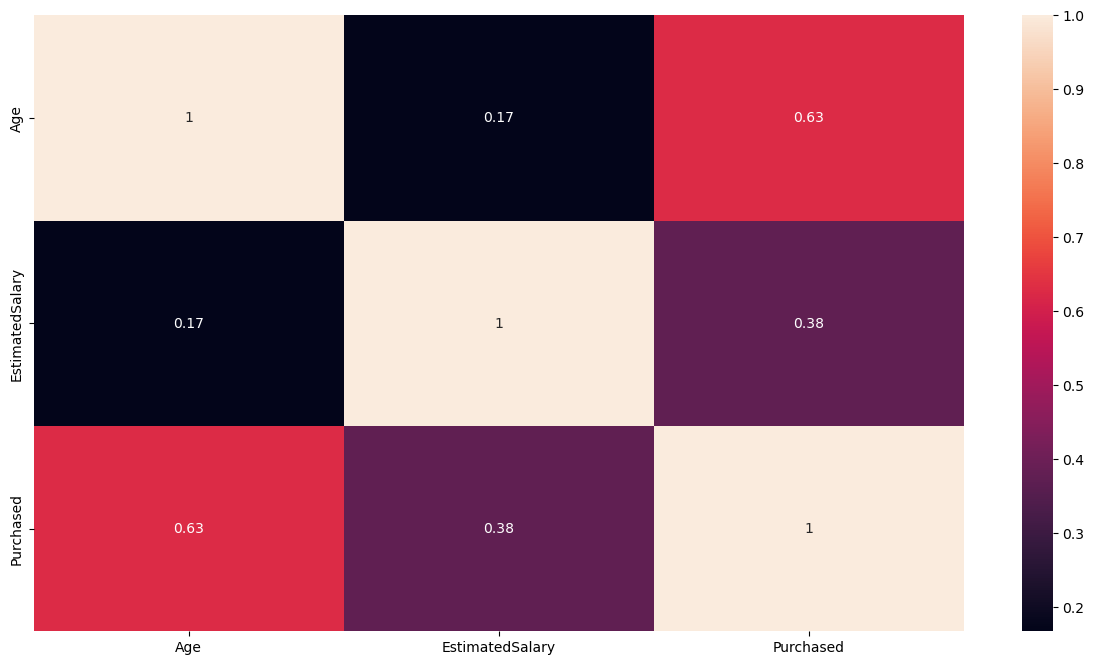

In [12]:
relations = df.corr()
plt.figure(figsize=(15,8))

sns.heatmap(data=relations, annot=True)

<Axes: xlabel='Age', ylabel='EstimatedSalary'>

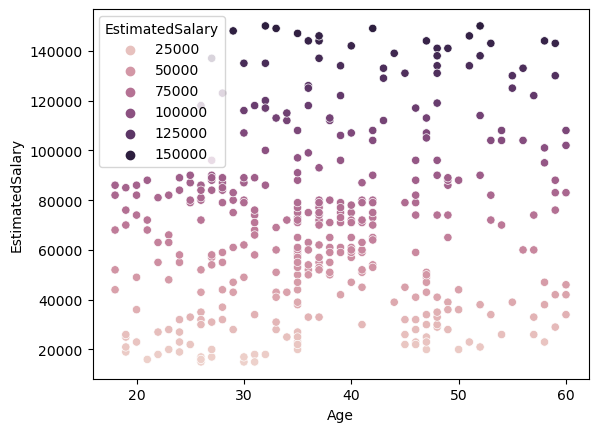

In [15]:
sns.scatterplot(data=df, x="Age", y ="EstimatedSalary", hue="EstimatedSalary")

# Split Feature Labels

In [17]:
X,y = df.drop("Purchased", axis=1), df["Purchased"]

# Baseline Model Evaluation

In [18]:

model = DummyClassifier(strategy="uniform")
scores = evaluate_model(X,y, model)
print('>%.3f (%.3f)' % (np.mean(scores), np.std(scores)))

>0.526 (0.077)


# 52% is the baseline model we should outperform.

# Spot Check Algorithms

In [19]:
spot_check_models(X, y)

2024-04-20 17:24:50.849304: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 0s 662us/step - loss: 0.3019 - accuracy: 0.9099


,Model,Accuracy
10,Sequential,0.909910
2,GPC,0.900901
4,SVC,0.900901
5,KNeighborsClassifier,0.873874
8,GradientBoostingClassifier,0.873874
9,XGB,0.873874
0,GaussianNB,0.855856
7,RandomForestClassifier,0.846847
3,LogisticRegression,0.828829
1,LDA,0.819820


# Advanced Model spot checking

In [21]:
names = ["GPC", "SVC", "LR", "LDA", "KNN", "GNB", "DTC", "RFC", "XGB", "GBC"]
models = get_selected_models(names)

testing_selected_models(names, models, X, y)

>GPC 0.895 (0.057)
>SVC 0.898 (0.059)
>LR 0.826 (0.063)
>LDA 0.831 (0.059)
>KNN 0.887 (0.050)
>GNB 0.884 (0.060)
>DTC 0.842 (0.061)
>RFC 0.879 (0.054)
>XGB 0.872 (0.056)
>GBC 0.880 (0.055)


# Best performing Models are 
1. SVC
2. GPC
3. RFC
4. KNN
5. GBC
6. GNB

# MLP Tuning

In [26]:
from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2, l1

def create_keras_classifier(function, optimizer, idx, param):
    if idx == 0:
        
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer)
            , epochs=100, 
            batch_size=64, 
            verbose=0
            )
    elif idx ==1:
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer, param=param)
            , epochs=100, 
            batch_size=64, 
            verbose=0
            )
        
    else:
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer, param=param)
            , epochs=100, 
            batch_size=64, 
            verbose=0
            )
    return model

def create_model_dropout(input_dim, optimizer='adam'):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_regularizerl2(input_dim, optimizer="adam",param= 0.001):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu', kernel_regularizer=l2(param) ))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_regularizerL1(input_dim, optimizer="adam",param= 0.001):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu', activity_regularizer=l1(param) ))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
functions = [
  create_model_dropout,
  create_model_regularizerL1,
  create_model_regularizerl2
]
# Define the optimizers to iterate over
optimizers = [
    Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07),
    SGD(lr=0.01, momentum=0.9), 
    SGD(lr=0.001, momentum=0.9),
    ]
optimizer_names = ['Adam', "RmsProp", "SGD:0.01", "SGD:0.001"]
function_names = ["Dropout", "L1", "L2"]
values = [1e-1, 1e-2, 1e-3, 1e-4]
for index, function in enumerate(functions):
    for idx, optimizer in enumerate(optimizers):
        print(f"Training with optimizer: {optimizer_names[idx]}, Values: {values[idx]}")
        model = create_keras_classifier(function, optimizer, index, values[idx])

        # Create the pipeline
        pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('power_transformer', PowerTransformer()),
        ('model', model)
        ])
        
        pipeline.fit(X_train, y_train)
        accuracy = pipeline.score(X_test, y_test)
        print(f'Model accuracy with {idx} optimizer:', accuracy)

/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_16405/3996620235.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(


Training with optimizer: Adam, Values: 0.1
Model accuracy with 0 optimizer: 0.9099099040031433
Training with optimizer: RmsProp, Values: 0.01


/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_16405/3996620235.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(


Model accuracy with 1 optimizer: 0.9099099040031433
Training with optimizer: SGD:0.01, Values: 0.001


/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_16405/3996620235.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(


Model accuracy with 2 optimizer: 0.9099099040031433
Training with optimizer: SGD:0.001, Values: 0.0001


/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_16405/3996620235.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(


Model accuracy with 3 optimizer: 0.8558558821678162
Training with optimizer: Adam, Values: 0.1


/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_16405/3996620235.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(


Model accuracy with 0 optimizer: 0.9009009003639221
Training with optimizer: RmsProp, Values: 0.01


/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_16405/3996620235.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(


Model accuracy with 1 optimizer: 0.9009009003639221
Training with optimizer: SGD:0.01, Values: 0.001


/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_16405/3996620235.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(


Model accuracy with 2 optimizer: 0.9099099040031433
Training with optimizer: SGD:0.001, Values: 0.0001


/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_16405/3996620235.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(


Model accuracy with 3 optimizer: 0.837837815284729
Training with optimizer: Adam, Values: 0.1


/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_16405/3996620235.py:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(


Model accuracy with 0 optimizer: 0.9099099040031433
Training with optimizer: RmsProp, Values: 0.01


/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_16405/3996620235.py:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(


Model accuracy with 1 optimizer: 0.9099099040031433
Training with optimizer: SGD:0.01, Values: 0.001


/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_16405/3996620235.py:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(


Model accuracy with 2 optimizer: 0.9099099040031433
Training with optimizer: SGD:0.001, Values: 0.0001


/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_16405/3996620235.py:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(


Model accuracy with 3 optimizer: 0.8018018007278442
